### Importing libraries

In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from pprint import pprint
from time import time
import logging
import itertools
plt.style.use('bmh')

# Question 1: Propensity score matching

## Loading the data

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

The dataset contains 614 observations.
We observe that the categorical variables are encoded using dummy varibales, i.e. binary variables. We are going to stick with this encoding as it is advantegous for the regression task that we are going to perform later. 



In [35]:
lalonde_data = pd.read_csv("lalonde.csv")
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [36]:
len(lalonde_data)

614

## 1. A naive analysis

To begin with, we compare the distribution of the outcome variable (re78) between the two groups in a naive way. This means that we do not consider relationships between the outcome variable and other available features, and just focus on the differences (possibly) induced by participating in the job training program.

We compare the distributions based on:

1. Boxplot diagrams
2. Histograms
3. QQ plots
4. Summary statistics
5. Mann-Whitney-U test (sometimes also referred to as Wilcoxon signed rank test.)

For these steps of the analysis we define the following functions:

In [37]:
treat = {0: 'treated', 1: 'control'}

def draw_box(df, col):
    """Draw a box plot for the values of the specified column for each of the two groups"""
    df.boxplot(by='treat', column=col, figsize = [5, 5], grid=False)
    plt.show()

def draw_hist(df, col):
    """Draw histograms and kernel density estimation plots for the specified column.
    Two plots are created for the two groups but displayed in two overlapping layers for comparison.
    """
    fig_hist, axs_hist = plt.subplots(nrows=2, sharex=True)
    df.groupby("treat")[col].plot(kind='kde', ax=axs_hist[1])
    axs_hist[1].set_xlabel(col)
    axs_hist[1].set_xlim(xmin=0)
    groups = df.groupby("treat")[col]
    for k, v in groups:
        v.hist(label=treat[k], alpha=.75, ax=axs_hist[0], bins=15, range=[df[col].min(), df[col].max()], figsize = [8, 5])
    axs_hist[0].legend()
    axs_hist[0].set_ylabel('number of participants')
    plt.show()

def draw_qqs(df, col):
    """Draw a QQ plot for both groups to find out more about the distribution of the data.
    NB: A comparison to a normal distribution with fitted parameters is performed."""
    fig_qq, axs_qq = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    stats.probplot(df[df.treat == 0][col], dist="norm", plot=axs_qq[0])
    axs_qq[0].set_title('Control Group')
    axs_qq[0].set_ylim(ymin=0)
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=axs_qq[1])
    axs_qq[1].set_title('Treatment Group')
    plt.show()
    
def get_summary(df, col):
    """Print summary statistics for both groups."""
    print('Control group')
    print('================================================')
    print(round(df[df.treat == 0][col].describe(), 2))
    print('================================================')
    print()
    print('Treatment group')
    print('================================================')
    print(round(df[df.treat == 1][col].describe(), 2))

def test(df, col):
    """Perform Mann-Whitney-U test and pretty print result.""" 
    s, p = stats.mannwhitneyu(df[df.treat == 0][col], df[df.treat == 1][col])
    print('Mann-Whitney-U test:')
    print('================================================')
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

Furthermore, we define a function that invokes all the functions for numerical features and displays the output in a structured way.

In [38]:
def analyse_numeric(df, col, detailed=True):    
    """Perform analysis for a numerical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_box(df, col)
    draw_hist(df, col)
    if(detailed):
        draw_qqs(df, col)
    print()
    get_summary(df, col)
    print()
    test(df, col)
    print()
    print()

Let us now analyse the distribution of the real earnings in 1978 within the two groups. The boxplot diagram shows that the median earning differs only slightly between the groups, and also the distributions are similar considering the interquartile range which is a measure of dispersion. However, we observe that there are some outliers in the treatment group that exhibit high earnings. The tables below give a numerical summary of the distribution of earnings within the groups. Interestingly, the upper quartile earning is higher in the control than in the treatment group.
The similarity between the two distributions is even more clearly visible from the kernel density estimates (or the histograms). To determine whether the observed (minor) differences are of significance, statistical test shall be computed. With numeric features, the t-test is a common means to test differences between the mean value of two groups. One necessary condition to use the t-test is that the features follow a normal distribution. To determine this, Quantile-Quantile Plots are drawn which show clear deviations from normality (normality would be fulfilled if the blue points would be evenly grouped around the diagonal). In the absence of normality, the Wilcoxon signed rank test is a nonparametric alternative. Here, we compare group medians instead of means. Regarding the earnings in 1978, the Wilcoxon test shows no significant difference between the medians of the two groups at a test level of 0.05 (p-value = 0.1409). This is in accordance with our observations from the boxplot diagram or histogram/density estimates.

                                   re78


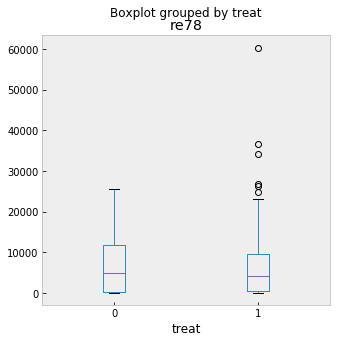

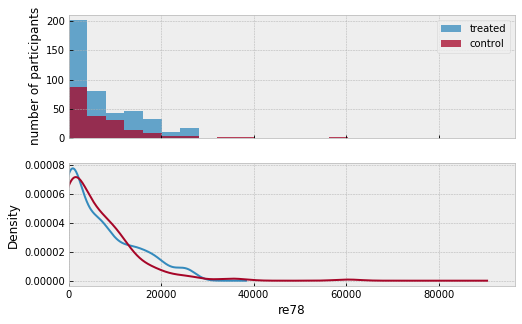

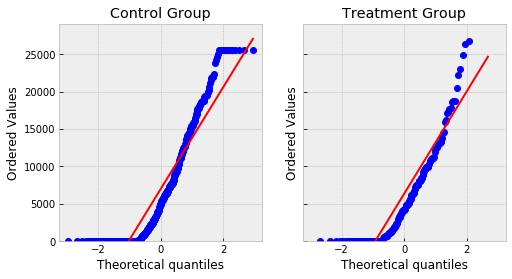


Control group
count    429.00  
mean     6984.17 
std      7294.16 
min      0.00    
25%      220.18  
50%      4975.50 
75%      11688.82
max      25564.67
Name: re78, dtype: float64

Treatment group
count    185.00  
mean     6349.14 
std      7867.40 
min      0.00    
25%      485.23  
50%      4232.31 
75%      9643.00 
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1409
test statistic:  37525.0




In [39]:
analyse_numeric(lalonde_data, 're78')

## 2. A closer look at the data

In order to get a better understanding of whether our naive analysis was appropriate, we now compare the distributions of the other covariates within the treatment groups. This is necessary as the observed sample was not randomly drawn. If differences are observed, these could influence the outcome of the above analysis as one would assume, for example, older people to have higher income in general. The effect of the treatment might then be confounded with that of the age effect. 


### Analysis of quantitative features

To analyse possible imbalance, we analyse the numerical features using the same strategy as in Part 1.

Considering the age distribution between treatment and control group, differences are apparent. People in the treatment group tend to be younger than in the control group, although the median age is not significantly different (Wilcoxon rank sum test, p-value = 0.2598).


                                   age


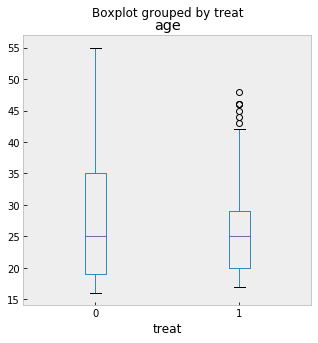

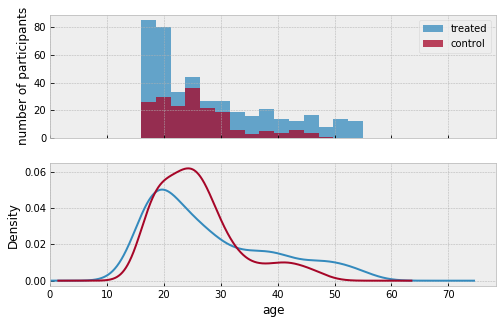

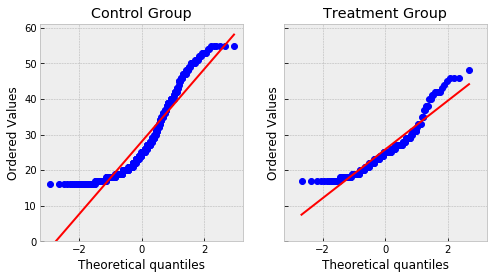


Control group
count    429.00
mean     28.03 
std      10.79 
min      16.00 
25%      19.00 
50%      25.00 
75%      35.00 
max      55.00 
Name: age, dtype: float64

Treatment group
count    185.00
mean     25.82 
std      7.16  
min      17.00 
25%      20.00 
50%      25.00 
75%      29.00 
max      48.00 
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.2598
test statistic:  38384.5




In [40]:
analyse_numeric(lalonde_data, 'age')

Considering years of education, differences are far less apparent. True, the control group exhibits outliers in both directions, but the median number of education years as well as the interquartile range is similar in both groups. Wilcoxon rank sum test gives again no significant result (p-value = 0.396).

                                   educ


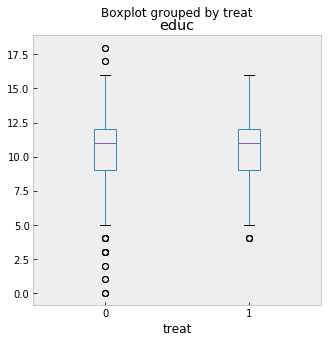

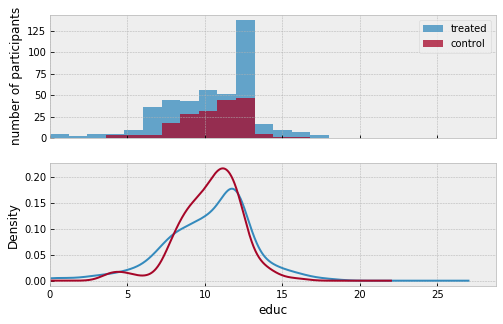

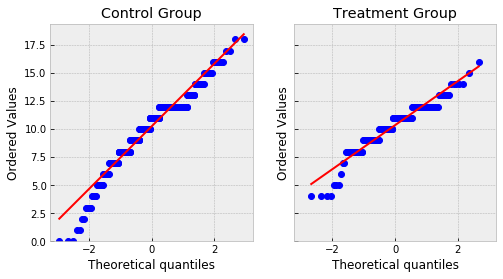


Control group
count    429.00
mean     10.24 
std      2.86  
min      0.00  
25%      9.00  
50%      11.00 
75%      12.00 
max      18.00 
Name: educ, dtype: float64

Treatment group
count    185.00
mean     10.35 
std      2.01  
min      4.00  
25%      9.00  
50%      11.00 
75%      12.00 
max      16.00 
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.396
test statistic:  39157.0




In [41]:
analyse_numeric(lalonde_data, 'educ')

Now, the earnings in 1974 show significant differences between the two groups. The boxplot diagram (or consult the tables below) shows that the median earning in the treatment group is 0, and people earning more than about 4000 are considered outliers. This difference is supported by a significant test result (p-value < 0.001), indicating that the earnings in 1974 were indeed significantly different between the two groups. The kernel density estimation is again a different way of visualizing this difference, showing that the mean earning in the control group is indeed higher than the treatment's group.

                                   re74


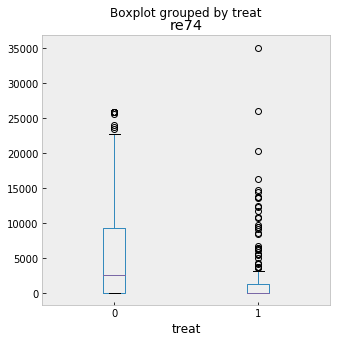

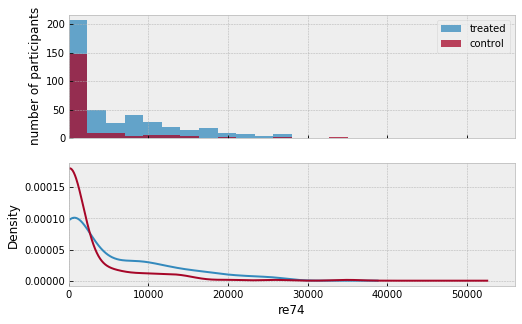

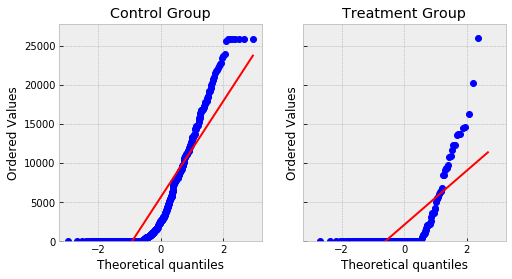


Control group
count    429.00  
mean     5619.24 
std      6788.75 
min      0.00    
25%      0.00    
50%      2547.05 
75%      9277.13 
max      25862.32
Name: re74, dtype: float64

Treatment group
count    185.00  
mean     2095.57 
std      4886.62 
min      0.00    
25%      0.00    
50%      0.00    
75%      1291.47 
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  21928.0




In [42]:
analyse_numeric(lalonde_data, 're74')

In concordance with the earnings in 1974, the same conclusions can be drawn for the earning in the consecutive year 1975. Here again, earnings are higher in the control than in the treatment group. These obvious differences lead us to conclude that there is a certain selection bias as to which persons are in the treatment group. This makes sense as people with less income or unemployed people might be more open to participating in a job training program. Again, Mann Whitney U Test gives a significant result (p-value < 0.001).

                                   re75


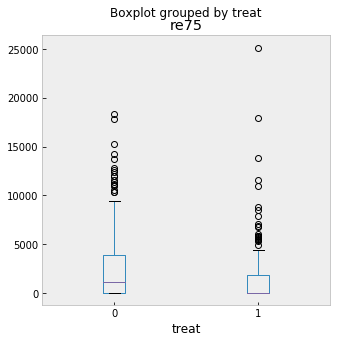

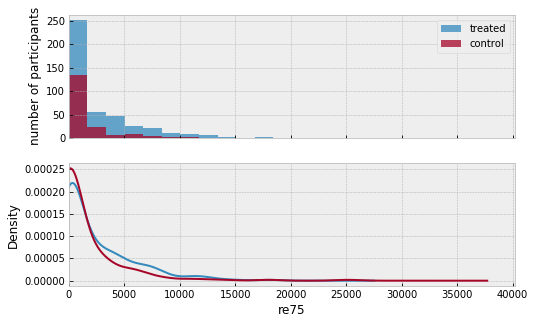

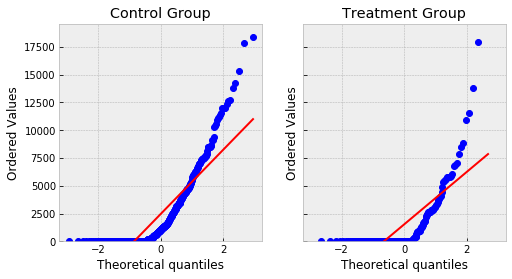


Control group
count    429.00  
mean     2466.48 
std      3292.00 
min      0.00    
25%      0.00    
50%      1086.73 
75%      3881.42 
max      18347.23
Name: re75, dtype: float64

Treatment group
count    185.00  
mean     1532.06 
std      3219.25 
min      0.00    
25%      0.00    
50%      0.00    
75%      1817.28 
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  28612.0




In [43]:
analyse_numeric(lalonde_data, 're75')

### Analysis of categorical features

It remains to take a closer look at the categorical covariates. As the methods used above are not appropriate for categorical variables, we need to define new functions for the analysis. For example, there is no point in drawing histograms for categrical variables, the thing to use here are bar plots. The chi-square test is used to analyse possible group differences.

In [44]:
def draw_bar(df, col):
    '''Draw a bar plot of the number of values in each category for the two groups'''
    df_grouped = df.groupby(['treat', col])[col].count()
    df_grouped = df_grouped.unstack()
    display(df_grouped)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    pl = df_grouped.plot(kind='bar', figsize=[5,5], rot=0)
    pl.set_title(col)
    pl.set_ylabel('proportion of participants')
    pl.set_xlabel('treatment group')
    plt.show()

For the race feature some preprocessing is needed in order to be able to draw a meaningful bar plot. Especially, the data frame does not contain a column for white people. We assume that individuals are white in case they are neither black nor hispanic.

In [45]:
def plot_race(df):
    '''Draw a bar plot for the race feature.'''
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    df_grouped = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
    del df['white']
    display(df_grouped)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    pl = df_grouped.plot(kind='bar', figsize=[7,5], rot=0)
    pl.set_title('race')
    pl.set_ylabel('proportion of participants')
    pl.set_xlabel('treatment group')
    plt.show()

In [46]:
def test_chisq(df, table):
    '''Perform chi square test'''
    print('Chi-square test')
    print('================================================')
    #perform test
    s, p, _, _ = stats.chi2_contingency(table)
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

In [47]:
def analyse_categoric(df, col):    
    """Perform analysis for a categorical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_bar(df, col)
    print()
    
    #compute contingency table and perform test
    df['neg'] = df[col].apply(lambda x: 1-x)
    table = df.groupby(df.treat)[col, 'neg'].sum()
    del df['neg']
    test_chisq(df, table)
    
    print()
    print()

In [48]:
def analyse_race(df):    
    """Perform analysis for the race feature and pretty print result."""
    print('=================================================================================')
    print('                                  race')
    print('=================================================================================')
    plot_race(df)
    print()
    print()
    
    #compute contingency table and perform test
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    table = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
    del df['white']
    
    test_chisq(df, table)

In the treatment group we find relatively more married people than in the control group. This difference is significant, or to put it in other words: there is a significant dependence between the marital state and group membership (Chi-square test, p-value < 0.001). However, this may also be due to the fact that the treatment group holds more young people, which tend to be not (yet) married. Here again might be some kind of confounding.analysis:

                                   married


married,0,1
treat,,
0,209,220
1,150,35


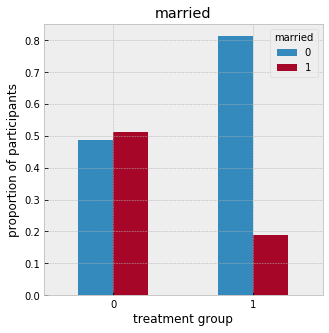


Chi-square test
p-value:  0.0
test statistic:  54.4




In [49]:
analyse_categoric(lalonde_data, 'married')

The same applies to *nodegree*, where we could find a significant relationship between group membership and *nodegree* (p-value = 0.0113).

                                   nodegree


nodegree,0,1
treat,,
0,173,256
1,54,131


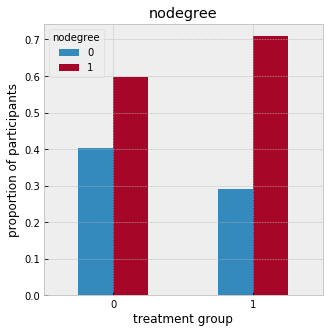


Chi-square test
p-value:  0.0113
test statistic:  6.4




In [50]:
analyse_categoric(lalonde_data, 'nodegree')

Finally, the participants race is included in the data as is often so with US studies. Interestingly, mostly black people participate in the treatment group. There are various studies analyzing the relationship between race and, for example, earnings. So here again, we find a possible source for confounding. The difference in earnings in the years 1974/5 might well be due to this difference in race structure between the two groups. However, no further analysis is conducted in this direction.

                                  race


,white,black,hispan
treat,,,
0,281,87,61
1,18,156,11


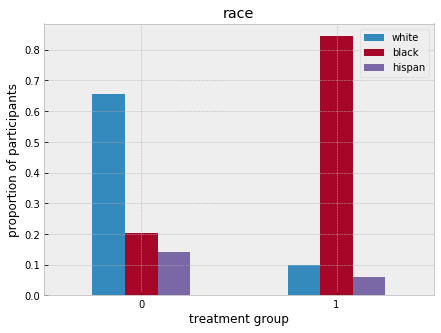



Chi-square test
p-value:  0.0
test statistic:  224.1


In [51]:
analyse_race(lalonde_data)

## 3. A propensity score model

We estimate propensity scores using logistic regression, that is we estimate the probability of receiving the treatment, based on the pre-treatment features.

In [52]:
logistic = linear_model.LogisticRegression()
#input features: everything but id, treat, and re78
logistic = logistic.fit(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1), lalonde_data.treat)
propensity_scores = logistic.predict_proba(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1))

The first column of the result contains the relevant score:

In [53]:
print(logistic.classes_)
print(propensity_scores[:5])

[0 1]
[[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]]


We store the result in a new column of the data frame in order to be able to use it for matching in the next step.

In [54]:
lalonde_data['propensity'] = propensity_scores[:, 1]

## 4. Balancing the dataset via matching

The goal is to use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. Furthermore, we want to minimize the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects.

As explained in the lecture this matching problem corresponds to finding a matching in a bipartite graph where the two groups correspond two the two sets of nodes. We therefore construct the corresponding graph from our dataset. For the python represetation of the graph we use the `networkx` package. We can then use the `max_weight_matching` function provided by the package to compute the matching.

To construct the graph we first compute the crossproduct of the observations in the treated group and the observations in the control group. That is, each data point from the treated group is combined with every data point from the control group. Then we compute a weight for each combination. Note that the goal is to minimize the sum of absolute propensity-score differences, while the package only provides a maximization method. So instead of minimizing the sum of absolute differences, we maximize the sum of negated absolute differences. However, the algorithm can not deal with negative weights. Therefore, we add 1 to every weight. This ensures that the weights are positive (as the difference of propensity scores can be maximal 1), while it does not affect the relative order of the weights. Therefore, the same edges will be chosen in the end.

For the selected nodes the function returns a mapping, where each node is mapped to its partner. Therfore we can simply use the key list of this mapping to restrict the data set and for the balancing.

In [55]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1].assign(key=0), lalonde_data.reset_index()[lalonde_data.treat == 0].assign(key=0), on='key').drop('key', axis=1)
graph_data['weight'] = - np.abs(graph_data['propensity_x'] - graph_data['propensity_y']) + 1
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

We convince ourselves that indeed all data points of the treated group are contained in the matching and that that each data point from the control group is matched with at most one data point from the treated group:

In [56]:
len(matching) == 2 * len(lalonde_data[lalonde_data.treat == 1])

True

In [57]:
for key, value in matching.items():
    if(matching[value]!=key):
        print('something went wrong!')
print('Everything alright!')

Everything alright!


In [58]:
if(len(matching.values()) == len(set(matching.values()))):
    print('Everything alright!')

Everything alright!


In [59]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
104,NSW105,1,19,11,1,0,0,1,0.0,0.0,7458.105,0.676164
572,PSID388,0,19,11,1,0,0,1,0.0,0.0,16485.520,0.676164
103,NSW104,1,18,11,1,0,0,1,0.0,0.0,4814.627,0.677650
558,PSID374,0,18,11,1,0,0,1,0.0,0.0,0.000,0.677650
91,NSW92,1,17,10,1,0,0,1,0.0,0.0,0.000,0.693346


## Analysis as in part 1 and 2 

After balancing in the previous step, the comparison of earnings in the treatment and control group shows again no significant difference in earnings (p-value = 0.1754). However, the earnings' distributions have changed such that earnings in the treatment tend now to be slightly higher than those in the control group (which was just the other way round before balancing).

                                   re78


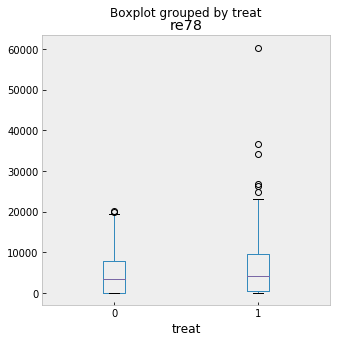

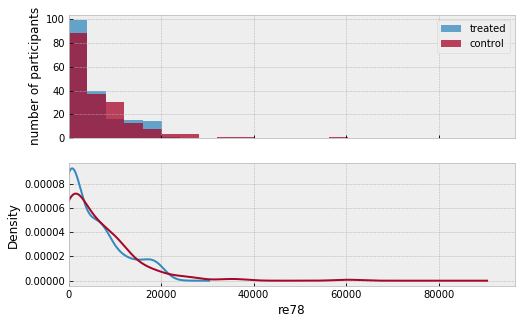


Control group
count    185.00  
mean     5312.47 
std      5842.88 
min      0.00    
25%      0.00    
50%      3392.86 
75%      7933.91 
max      20243.38
Name: re78, dtype: float64

Treatment group
count    185.00  
mean     6349.14 
std      7867.40 
min      0.00    
25%      485.23  
50%      4232.31 
75%      9643.00 
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1754
test statistic:  16159.5




In [60]:
analyse_numeric(lalonde_data_balanced, 're78', detailed=False)

The other available features' distributions changed for some features. The distributions of age, as well as earnings in 1974 are still significantly different (p-value < 0.0001; p-value = 0.0002), although the differences are now much smaller regarding earnings in 1974. The distribution of years of education showed no significant difference before matching, neither does it afterwards. The same goes for earnings in 1975 (p-value = 0.0034). Martial state as well as `nodegree` show balanced proportions after matching, while the race membership still shows significant differences between the groups (p-value < 0.0001).

                                   age


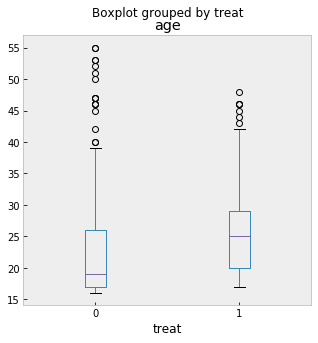

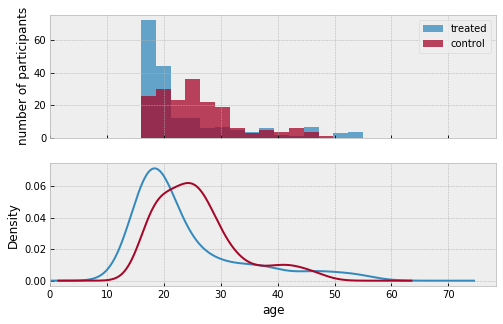


Control group
count    185.00
mean     23.71 
std      9.64  
min      16.00 
25%      17.00 
50%      19.00 
75%      26.00 
max      55.00 
Name: age, dtype: float64

Treatment group
count    185.00
mean     25.82 
std      7.16  
min      17.00 
25%      20.00 
50%      25.00 
75%      29.00 
max      48.00 
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  11661.5




In [61]:
analyse_numeric(lalonde_data_balanced, 'age', detailed=False)

                                   educ


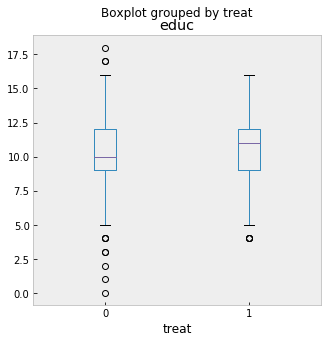

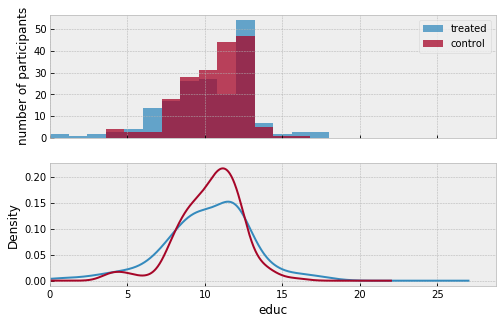


Control group
count    185.00
mean     10.16 
std      2.86  
min      0.00  
25%      9.00  
50%      10.00 
75%      12.00 
max      18.00 
Name: educ, dtype: float64

Treatment group
count    185.00
mean     10.35 
std      2.01  
min      4.00  
25%      9.00  
50%      11.00 
75%      12.00 
max      16.00 
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.3611
test statistic:  16751.0




In [62]:
analyse_numeric(lalonde_data_balanced, 'educ', detailed=False)

                                   re74


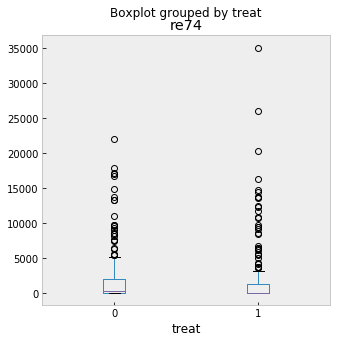

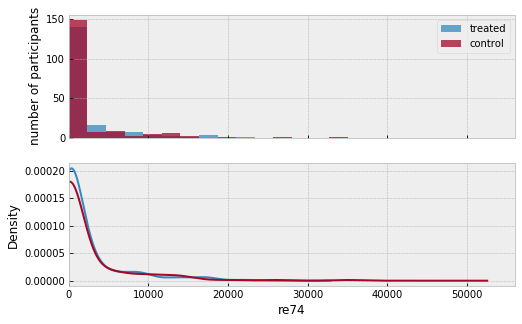


Control group
count    185.00  
mean     2095.89 
std      4029.20 
min      0.00    
25%      0.00    
50%      289.97  
75%      2068.99 
max      21918.32
Name: re74, dtype: float64

Treatment group
count    185.00  
mean     2095.57 
std      4886.62 
min      0.00    
25%      0.00    
50%      0.00    
75%      1291.47 
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0002
test statistic:  13873.0




In [63]:
analyse_numeric(lalonde_data_balanced, 're74', detailed=False)

                                   re75


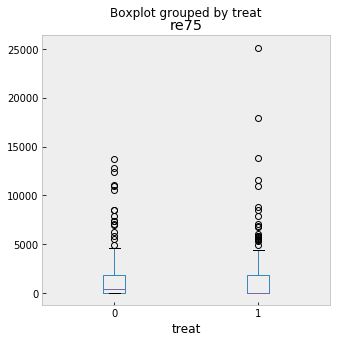

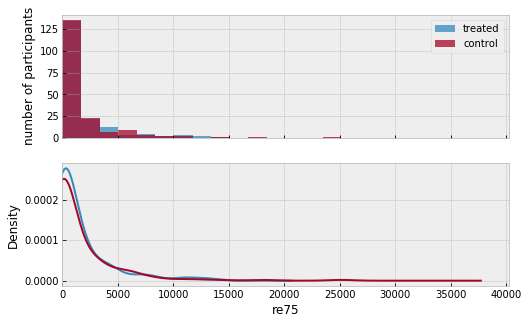


Control group
count    185.00  
mean     1615.31 
std      2674.75 
min      0.00    
25%      0.00    
50%      451.16  
75%      1890.58 
max      13776.53
Name: re75, dtype: float64

Treatment group
count    185.00  
mean     1532.06 
std      3219.25 
min      0.00    
25%      0.00    
50%      0.00    
75%      1817.28 
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0034
test statistic:  14504.0




In [64]:
analyse_numeric(lalonde_data_balanced, 're75', detailed=False)

                                   married


married,0,1
treat,,
0,154,31
1,150,35


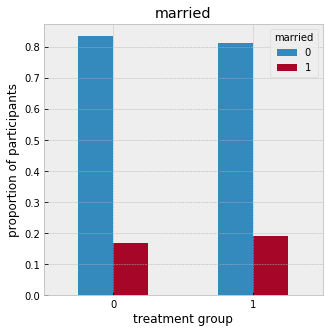


Chi-square test
p-value:  0.6837
test statistic:  0.2




In [65]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


nodegree,0,1
treat,,
0,69,116
1,54,131


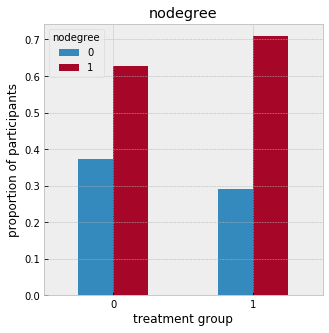


Chi-square test
p-value:  0.1223
test statistic:  2.4




In [66]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


,white,black,hispan
treat,,,
0,76,87,22
1,18,156,11


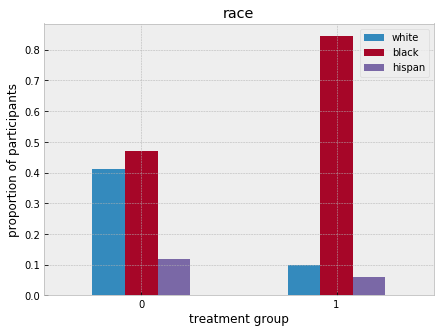



Chi-square test
p-value:  0.0
test statistic:  59.0


In [67]:
analyse_race(lalonde_data_balanced)

These obvious differences in distributions indicate that the balancing progress did not address all features properly. Especially the imbalance in race is a serious problem as we might assume a strong relationship between race and earnings in general, at least back in 1978. Therefore it is essential that the sample be balanced concerning race at least. Also, the balancing of the age feature is still problematic. This could affect the outcome, as it is likely that there is a relationship between age and earnings.

## 5. Balancing the groups further

As discussed above, one of the most problematic features is race. Therefore, we try to improve the balancing by making sure that only subjects that have the same race can be matched. The reason that we chose race over other problematic features like age for the refinement is that matching on equality makes more sense for categoric features with few possible values.


We use the same matching procedure as above, but construct a slightly different graph. In particular, instead of computing the crossproduct of data points in the two groups, we join the two groups based on the `black` and `hispan` columns, i.e., on the race. Hence, in the constructed graph there are no edges between nodes corresponding to subjects with different races and they therefore cannot be selected in the matching.

In [68]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1], lalonde_data.reset_index()[lalonde_data.treat == 0], on=['black', 'hispan'])
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [69]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
104,NSW105,1,19,11,1,0,0,1,0.0,0.0,7458.105,0.676164
572,PSID388,0,19,11,1,0,0,1,0.0,0.0,16485.520,0.676164
103,NSW104,1,18,11,1,0,0,1,0.0,0.0,4814.627,0.677650
558,PSID374,0,18,11,1,0,0,1,0.0,0.0,0.000,0.677650
91,NSW92,1,17,10,1,0,0,1,0.0,0.0,0.000,0.693346


In [70]:
len(lalonde_data_balanced)

232

### Analysis

After balancing for race, proportions are now equal between the two groups. The age distribution still exhibits differences (p-value = 0.0088), the control group consisting of slightly older people. Also, the other features do not exhibit interesting changes compared to the first balancing step.

                                   age


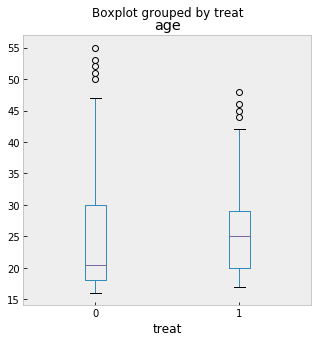

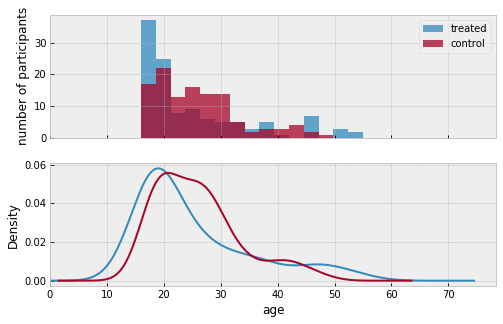


Control group
count    116.00
mean     25.25 
std      10.15 
min      16.00 
25%      18.00 
50%      20.50 
75%      30.00 
max      55.00 
Name: age, dtype: float64

Treatment group
count    116.00
mean     25.90 
std      7.39  
min      17.00 
25%      20.00 
50%      25.00 
75%      29.00 
max      48.00 
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0088
test statistic:  5515.5




In [71]:
analyse_numeric(lalonde_data_balanced, 'age', detailed=False)

                                   educ


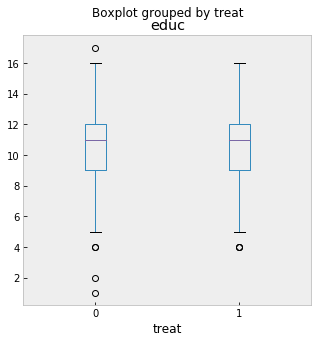

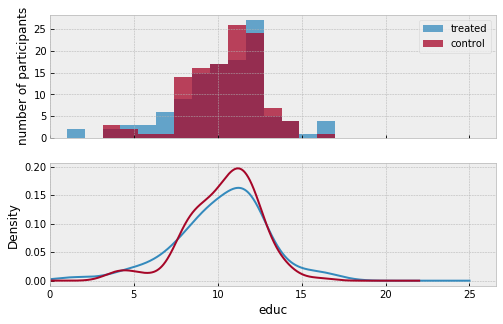


Control group
count    116.00
mean     10.22 
std      2.73  
min      1.00  
25%      9.00  
50%      11.00 
75%      12.00 
max      17.00 
Name: educ, dtype: float64

Treatment group
count    116.00
mean     10.33 
std      2.14  
min      4.00  
25%      9.00  
50%      11.00 
75%      12.00 
max      16.00 
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.4484
test statistic:  6662.0




In [72]:
analyse_numeric(lalonde_data_balanced, 'educ', detailed=False)

                                   re74


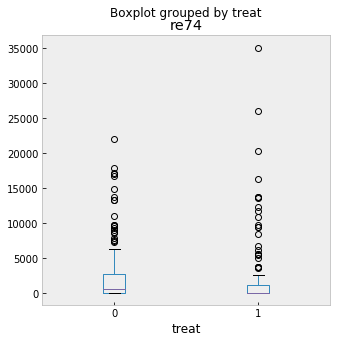

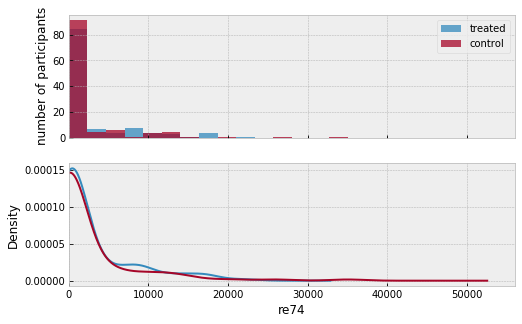


Control group
count    116.00  
mean     2846.65 
std      4818.60 
min      0.00    
25%      0.00    
50%      515.29  
75%      2760.12 
max      21918.32
Name: re74, dtype: float64

Treatment group
count    116.00  
mean     2351.18 
std      5535.98 
min      0.00    
25%      0.00    
50%      0.00    
75%      1171.08 
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0001
test statistic:  5039.5




In [73]:
analyse_numeric(lalonde_data_balanced, 're74', detailed=False)

                                   re75


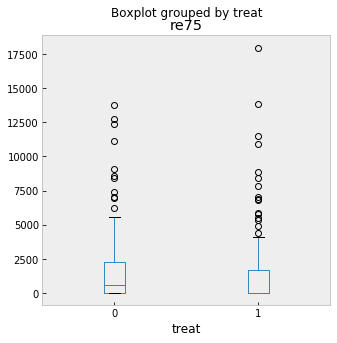

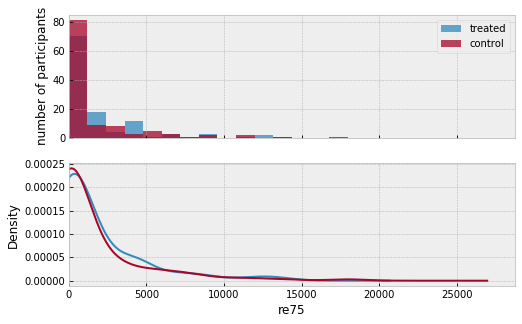


Control group
count    116.00  
mean     1882.17 
std      2943.71 
min      0.00    
25%      0.00    
50%      555.00  
75%      2302.80 
max      13776.53
Name: re75, dtype: float64

Treatment group
count    116.00  
mean     1587.20 
std      3128.63 
min      0.00    
25%      0.00    
50%      0.00    
75%      1677.87 
max      17976.15
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0082
test statistic:  5575.5




In [74]:
analyse_numeric(lalonde_data_balanced, 're75', detailed=False)

                                   married


married,0,1
treat,,
0,85,31
1,88,28


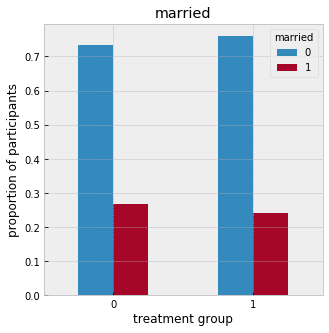


Chi-square test
p-value:  0.763
test statistic:  0.1




In [75]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


nodegree,0,1
treat,,
0,41,75
1,36,80


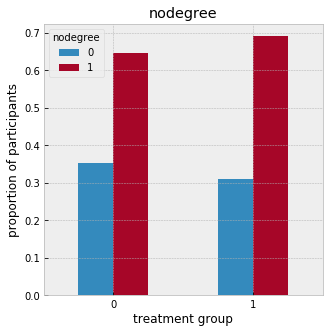


Chi-square test
p-value:  0.5771
test statistic:  0.3




In [76]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


,white,black,hispan
treat,,,
0,18,87,11
1,18,87,11


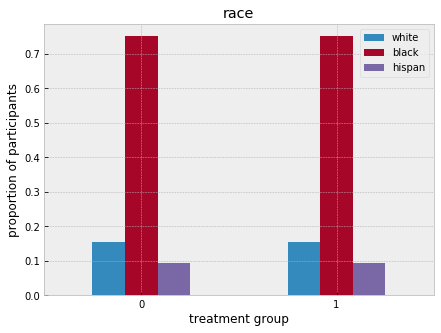



Chi-square test
p-value:  1.0
test statistic:  0.0


In [77]:
analyse_race(lalonde_data_balanced)

## 6. A less naive analysis

After two-step balancing, we again consider the distribution of the outcome variable (earnings in 1978). Both the boxplot diagram and the density estimates indicate a difference in earnings between treatment and control group. While the median earning in the control group was 2283 USD, it was higher in the treatment group at 5131 USD. This difference in medians is statistically significant (p-value = 0.0249). From this we conclude that the job training program was indeed effective, quite contrary to the impression we got in the initial analysis (before matching). This shows the importance of considering the data collection process and data quality. In the absence of a sampling design featuring random sampling, balancing techniques can be applied to draw valid conclusions.

                                   re78


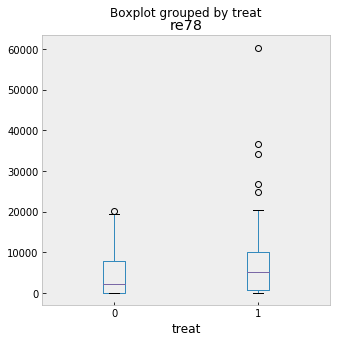

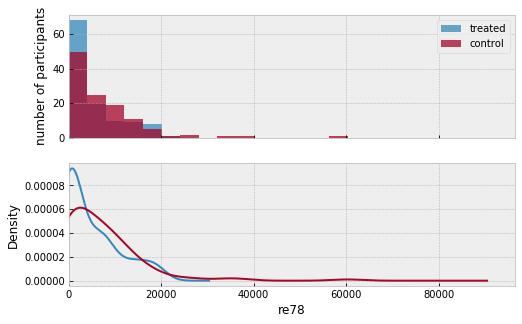


Control group
count    116.00  
mean     4968.64 
std      5855.64 
min      0.00    
25%      0.00    
50%      2283.09 
75%      7866.31 
max      20243.38
Name: re78, dtype: float64

Treatment group
count    116.00  
mean     7070.71 
std      8607.70 
min      0.00    
25%      672.49  
50%      5130.76 
75%      10011.05
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.0249
test statistic:  5731.0




In [78]:
analyse_numeric(lalonde_data_balanced, 're78', detailed=False)

# Question 2: Applied ML

### Importing sklearn modules
___

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix

### Preprocessing Data
___
This function preprocess our dataset:
- TF-IDF, is used to represent the importance of the words inside their context
- SPLIT, is used to split the dataset into two portions defined by RATIO of **training** and **testing**

The stratify parameter is used to balance the distribution of training and testing set over all the classes.

In [2]:
def preprocess_data(data, vectorizer, ratio=0.9):
    '''
    Function used to preprocess the dataset, vectorize, and split it in training and testing portions.
    Params:
        @data: the dataset that will be split and vectorized
        @vectorizer: used to vectorize the data
        @ratio: the ratio used to split the dataset
    '''
    X = vectorizer.fit_transform(data.data)
    return train_test_split(X, data.target, test_size=1-ratio, random_state=0, stratify=data.target)

### Coarse-to-fine approach for hyper parameters optimization
To find the best parameters is commonly used a coarse-to-fine approach.
We first start with a wide range of parameters and we refine them as we get closer to the best results.
___
We declare the parameters we want to optimize:
- More parameters =  better exploring power 
- Less parameters = decreasing processing time

In the GridSearchCV function is possible to choose several parameters, in particular:
- **n_jobs**, are the threads used in the computations
- **verbose**, will show in verbose mode the output of the training
- **cv**, it's possible to specify how many folds to use in the cross validation
- **scoring**, the metric used for the training.

While the first parameters will not impact so much in the effective accuracy of the classifier, it's important to define a good scoring metric.

In our classification problem we need to maximize the number of samples that we correctly predict. For this reason we need to have a scoring metrics that focuses on the number of correct samples predicted over the total.
After this reasoning we choose to select the *'accuracy'* metric, which is the scoring metric the does what we need.

In [24]:
def estimate_parameters(train_X, train_Y, pipeline, parameters, n_jobs=4, verbose=1, cv=3):
    '''
    Function used to optimize parameters of the RandomForest using GridSearchCV.
    Params:
        @train_X: features dataset of training
        @train_Y: label dataset of training
        @pipeline: the parameters that are optimized 
        @parameters: the parameters ranges used for the optimization
        @n_jobs, used to parallelize the training.
        @verbose, output training in verbose mode.
        @cv, k-fold used.
    '''
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=n_jobs, verbose=verbose, cv=cv, scoring='accuracy')
    print('----------------------------------------')
    print("Cross validating with grid search for...")
    print([name for name, _ in pipeline.steps])
    print('----------------------------------------')
    print("Analyzed parameters:")
    pprint(parameters)
    print('----------------------------------------')
    t0 = time()
    grid_search.fit(train_X, train_Y)
    print("Fine tuning took %0.3fs" % (time() - t0))
    print("Best obtained is score: %0.3f" % grid_search.best_score_)
    best_estimator = grid_search.best_estimator_
    # print("Grid score results")
    # print(grid_search.cv_results_) # USED TO SEE THE RESULTS OF EVERY PARAMETERS COMBINATION
    return best_estimator

### Training Random Forest classifier
___
We build the Random Forest classifier specifying:
- number of estimators
- maximum depth of the forest

We train the model and return the classifier

In [4]:
def train_random_forest(X_train, y_train, n_estimators, max_depth):
    '''
    Function used to train the random forest classifier.
    Params:
        @train_X: features dataset of training
        @train_Y: label dataset of training
        @n_estimators: number of estimators in the random forest
        @max_depth: max depth of the random forest
    '''
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return rfc.fit(X_train, y_train)

### Plotting confusion matrix

We plot the confusion matrix of our classifier given the classes names.
__

In [5]:
def plot_confusion_matrix(cnf_matrix, class_names):
    '''
    Function used to plot the confusion matrix of the classified prediction.
    Params:
        @cnf_matrix: confusion matri of the prediction
        @class_names: label names
    '''
    norm_conf = []
    for i in cnf_matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)
    fig = plt.figure(figsize=(16, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')
    width, height = cnf_matrix.shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cnf_matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    cb = fig.colorbar(res)
    plt.xticks(range(width), class_names, rotation=90)
    plt.ylabel('True Label')
    plt.xlabel('Prediction Label')
    plt.yticks(range(height), class_names)

### Visualize importance of features and the distribution of the importance

In [6]:
def visualize_features_importance(classifier, n_features=50, y='Feature importance'):
    '''
    Function used to plot the confusion matrix of the classified prediction.
    Params:
        @classifier: random forest classifier
        @n_features: number of features to show
        @y: label for the features importance - 'Feature Importance' by default
    '''
    importances_feat = pd.DataFrame(classifier.feature_importances_)
    importances_feat.columns = [y]
    importances_feat = importances_feat.sort_values(y,ascending=False)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[16,10])
    plt.suptitle('Distribution of feature importance', x=0.5, y=1.00, ha='center', fontsize='xx-large')
    importances_feat.head(n_features).hist(ax=axes[0])
    importances_feat.head(n_features).plot(ax=axes[1],kind='bar', title='Importance of the features')
    return importances_feat

## Execution
___
Fetching dataset and preprocessing using the functions described above.

In [7]:
data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer()

### Analyzing the dataset
First thing we print the keys of the data, to check what are the columns that we're interested in.

In [8]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

We create a frame to analyze its structure and then we print its content.

In [12]:
df = pd.DataFrame(data={'document':data['data'], 'category':data['target']})

In [13]:
pd.set_option('display.max_colwidth', -1)
df.head()

,category,document
0,10,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n"
1,3,"From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which high-performance VLB video card?\nSummary: Seek recommendations for VLB video card\nNntp-Posting-Host: midway.ecn.uoknor.edu\nOrganization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA\nKeywords: orchid, stealth, vlb\nLines: 21\n\n My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n\n-- \n | Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu) | \n --+-- ""Now I, Nebuchadnezzar, praise and exalt and glorify the King --+-- \n | of heaven, because everything he does is right and all his ways | \n | are just."" - Nebuchadnezzar, king of Babylon, 562 B.C. | \n"
2,17,"From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)\nLines: 95\nNntp-Posting-Host: viktoria.dsv.su.se\nReply-To: hilmi-er@dsv.su.se (Hilmi Eren)\nOrganization: Dept. of Computer and Systems Sciences, Stockholm University\n\n\n\n\n|>The student of ""regional killings"" alias Davidian (not the Davidian religios sect) writes:\n\n\n|>Greater Armenia would stretch from Karabakh, to the Black Sea, to the\n|>Mediterranean, so if you use the term ""Greater Armenia"" use it with care.\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n|>It has always been up to the Azeris to end their announced winning of Karabakh \n|>by removing the Armenians! When the president of Azerbaijan, Elchibey, came to \n|>power last year, he announced he would be be ""swimming in Lake Sevan [in \n|>Armeniaxn] by July"".\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n|>Well, he was wrong! If Elchibey is going to shell the \n|>Armenians of Karabakh from Aghdam, his people will pay the price! If Elchibey \n\t\t\t\t\t\t ****************\n|>is going to shell Karabakh from Fizuli his people will pay the price! If \n\t\t\t\t\t\t ******************\n|>Elchibey thinks he can get away with bombing Armenia from the hills of \n|>Kelbajar, his people will pay the price. \n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORTURED BY THE ARMENIANS??????????\n\t\n\tHAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""???????\n\tYOU FACIST!!!!!\n\n\n\n\tOhhh i forgot, this is how Armenians fight, nobody has forgot\n\tyou killings, rapings and torture against the Kurds and Turks once\n\tupon a time!\n \n \n\n|>And anyway, this ""60 \n|>Kurd refugee"" story, as have other stories, are simp

### Splitting dataset
To train our Random Forest classifier we would like to split our dataset in a portion of training and testing. We are not splitting it in another portion for validation since the function **GridSearchCV** given by **Scikit-learn** takes care of the validation part (with the possibility to specify the number of folds _k_).

We specify the ratio the we use to split the dataset and the vectorizer used to parse the documents (in our case a TF-IDF Vectorizer).

In [14]:
X_train, X_test, y_train, y_test = preprocess_data(data, vectorizer, 0.9)

#### Pipeline and Parameters declaration
___
- TfidfVectorizer is our TF-IDF vectorizer for the sentences
- RandomForestClassifier is the classifier we are training

Note:
For further analysis it is possible to specify parameters also for the TfidfVectorizer, considering always that more parameters means more exploration power but more computation time also.

In [15]:
# Define a Pipeline
pipeline = Pipeline([
    #('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

### Parameters fine-tuning
___
Now we try to optimize our model by selecting a range for our parameters:
- **max_depth**: between 10 and 30
- **n_estimators**: between 100 and 400

As we have seen so far, those are the most reasonable values for each parameters. We now run the GridSearchCV to optimize them and search for the best ones.

In [16]:
parameters = {
    'clf__max_depth': (10, 20, 30),
    'clf__n_estimators': (100, 200, 400),
}

In [17]:
best_estimator = estimate_parameters(X_train, y_train, pipeline, parameters)

----------------------------------------
Cross validating with grid search for...
['clf']
----------------------------------------
Analyzed parameters:
{'clf__max_depth': (10, 20, 30), 'clf__n_estimators': (100, 200, 400)}
----------------------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  8.3min finished


Fine tuning took 616.640s
Best obtained is score: 0.816


In [18]:
best_estimator

Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### Trade-off - Performance vs Accuracy
As we can see from the previous testing, the best results are obtained with the highest values of our parameters.
So, we decide to increase the value of estimators and the max depth of the forest to see if we obtain better results without impacting to much on the performances.

For the next testing:
- **max_depth**: between 30 and 50
- **n_estimators**: between 400 and 800

In [26]:
parameters = {
    'clf__max_depth': (30, 40, 50),
    'clf__n_estimators': (400, 500, 600),
}

In [27]:
best_estimator = estimate_parameters(X_train, y_train, pipeline, parameters)

----------------------------------------
Cross validating with grid search for...
['clf']
----------------------------------------
Analyzed parameters:
{'clf__max_depth': (30, 40, 50), 'clf__n_estimators': (400, 500, 600)}
----------------------------------------
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 17.4min finished


Fine tuning took 1344.064s
Best obtained is score: 0.838


In [28]:
best_estimator

Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### Observations on the parameters optimization
Like the first time we obtain the best results with the highest values. This time the computation took a big amount of time. For this reason we will not explore other values since as we can notice we are already loosing in terms of performance without having a significant bonus in the accuracy.

### Training
We train the RandomForest classifier with the best parameters obtained after our cross validation to predict the category of each news email. 

In [29]:
params = best_estimator.get_params()

In [30]:
classifier = train_random_forest(X_train, y_train, 
                    params.get('clf__n_estimators'), 
                    params.get('clf__max_depth'))

### Testing

We test the classifier with the test set that we splitted before.

In [31]:
classifier.score(X_test, y_test)

0.84190981432360745

### Plotting confusion Matrix

We plot the confusion matrix:

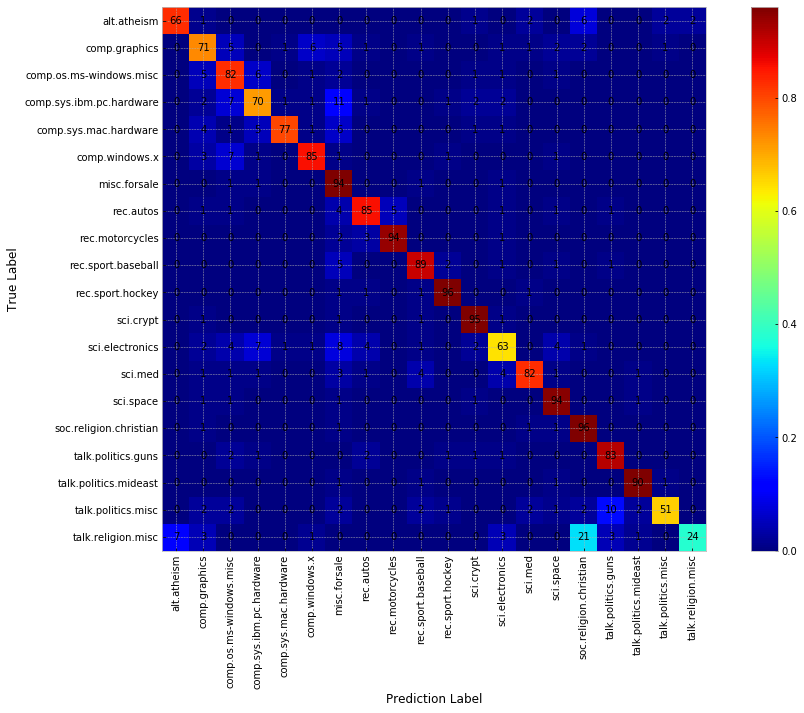

In [32]:
y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = data.target_names
plot_confusion_matrix(cnf_matrix, class_names)

#### Observations:
As we can see from the confusion matrix some of the categories are quite related, and this is why sometimes our classifier is not accurate. For instance **sci.electronics** is sometimes interpreted a **msc.forsale** which is intuitively right.
The most evident category that we see is misunderstood is **talk.religion.misc**, which is often classified as **soc.religion.christian**, in fact both share common topics.

We can state that our classifier performs well, however it still has some problems while trying to classify topic-related documents. In fact, the TF-IDF vectorizer assings importances to features based on their frequency in the document and their global frequency. This is the reason why our classifier encounters some problems when classifying similar categories.
___
### Plotting features importance and distribution

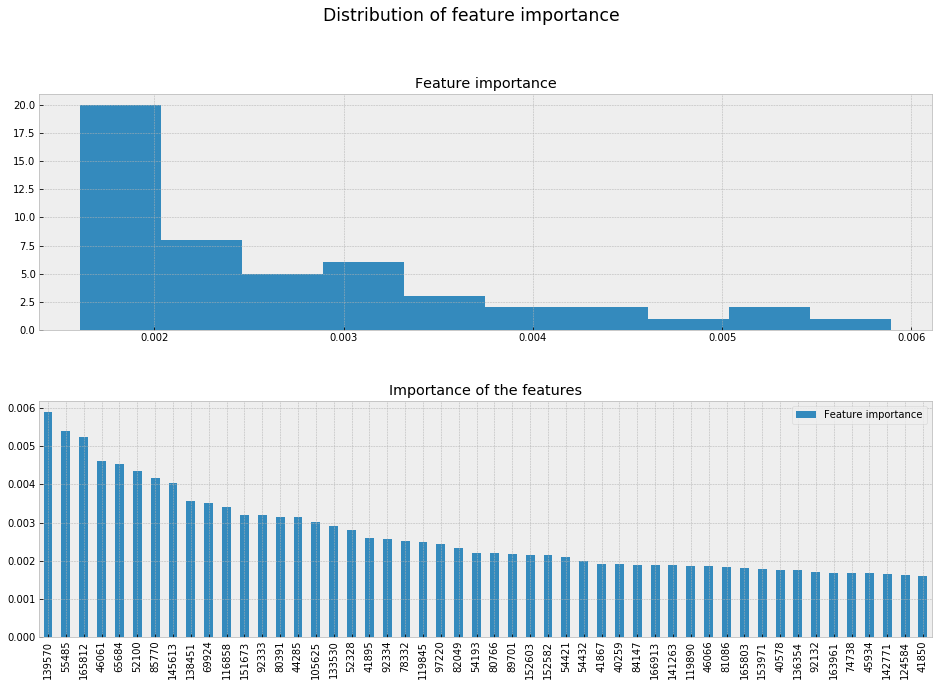

In [33]:
importances_feat = visualize_features_importance(classifier)

#### Description of the feature importance

In [34]:
importances_feat.describe()

,Feature importance
count,1.737620e+05
mean,5.754998e-06
std,6.565446e-05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,7.351737e-07
max,5.893963e-03


#### Observations:
As we can see from the values in the description above:
- The entire first quartile is useless across all the decision trees.
- The second quartile don't have a big importance.
- The third one is comparable (even if lower) with the mean of the values, and that means that it's important in the process of classification.

Given this results, we can state that this behaviour is reasonable since giving importances to different features instead of giving importance to a small subset can prevent overfitting in a decision tree. Furthermore, both the bar plots above, (the distribution of importance and the importance of each feature) show that the majority of the features (approximately 75%) don't have a big importance. This plot matches our previous assumption given the description of the feature importances. Standard deviation is also really high, this is related to the high dimensionality of the number of estimators.